In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals
from keras import models
from keras import optimizers
from keras import callbacks
from keras.optimizers import Adam
from keras import layers
from keras.utils.vis_utils import plot_model
import keras.backend as K

import tensorflow as tf

import numpy as np
import skimage
import cv2
import scipy.io
import pprint
import glob

import PIL as pillow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
from matplotlib import pyplot as plt
import matplotlib

from keras.engine.topology import Layer

from mpl_toolkits.mplot3d import Axes3D
from keras.models import load_model

import json



import random
from sklearn.model_selection import train_test_split

# tf.enable_eager_execution()

%matplotlib inline

Using TensorFlow backend.


In [2]:
labels_model= ['auto','people','tree','beton','sign']
num_classes = len(labels_model)

IMAGE_H, IMAGE_W, IMAGE_D = 1024, 256, 80
GRID_H,  GRID_W, GRID_D = 16,8,5
BOX              = 5
CLASS            = len(labels_model)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
# ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
# anchors_list = [[60,60,40],[50,40,40],[40,40,40], [20,20,40], [10,10,40],[30,30,40]]
# anchors_list = [[40,130,40],[35,90,40],[70,65,40], [65,105,40], [30,65,40],[120,110,40]] #new ones
anchors_list = [[40,120,40],[35,60,40],[205,110,40], [40,100,40], [50,150,40],[75,110,40]] #new new ones
num_boxes = len(anchors_list)

BATCH_SIZE       = 1
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


ALPHA = 0.1

In [3]:
input_image = layers.Input(shape=(IMAGE_H/2,IMAGE_W/2,IMAGE_D/2,1))
true_boxes  = layers.Input(shape=(20, 5))
def get_model():
    
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same', name = 'conv_0_1')(input_image)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2,2,1))(x)
#     print(x.shape)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same',name = 'conv_1_1')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,4,4))(x)
#     print(x.shape)
    
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,2,2))(x)
    
    x = layers.Conv3D(filters = (4+1+num_classes)*num_boxes, kernel_size=(1,1,1), strides =(1,1,1), padding = 'same', name= 'yolo')(x)
#     print(x.shape)
    output = layers.Reshape((GRID_H,GRID_W,GRID_D,num_boxes, 4+1+num_classes))(x)
    
    output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model([input_image,true_boxes],output)
    return model

In [9]:
# model = Model(inputs = input,outputs = x)
model = get_model()
# model.summary()
mypotim=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


# model_loss = mine_loss()

model.compile(loss=model_loss, optimizer=mypotim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



In [321]:
# model.load_weights('weights_good_loader.h5')

In [6]:
directory_val = os.path.abspath('val_data')
pathname_val = os.listdir(directory_val)
def return_val():
    for file in pathname_val:
        matr = scipy.io.loadmat(os.path.join(directory_val,file))

        frame_data = np.zeros((40,512,128,40,1))
        targets_data = np.zeros((40,20,5))
        y_true_data = np.zeros((40,16,8,5,6,10))
        for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
        #                 true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = targets/2
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
        #                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

                    frame_data[num_frame,...] = frame
                    targets_data[num_frame,...] = targets[0]
                    y_true_data[num_frame,...] = y_true
    return ([frame_data,targets_data], y_true_data )


In [5]:
pathname = os.path.abspath('data')
def generator_2(pathname = pathname):
    while True:
        for file in random.shuffle(glob.glob(pathname+'/*.mat')):
            matr = scipy.io.loadmat(file)
            for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                Labels = Labels/2
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
                    true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                    yield ([frame,targets], y_true )

In [4]:
pathname = os.path.abspath('data')
dir_list = os.listdir(pathname)
full_frame_dir = []

for dir_item in dir_list:
    for num in range(40):
        full_frame_dir.append([os.path.join(pathname,dir_item), num])
#     print(os.path.join(pathname, dir_item))
# print(full_frame_dir[0])

train_list, test_list = train_test_split(full_frame_dir, train_size = 0.96)

def generator_train(train_list = train_list):
    while True:
        random.shuffle(train_list)
        for item in train_list:
            file = item[0]
            num_frame = item[1]
            matr = scipy.io.loadmat(file)
            Labels = np.array(matr["Labels"][num_frame])
            Labels = Labels/2
            object_mask = Labels[:,0]
            if object_mask.shape[0] != 0:
                true_boxes = Labels[:,:]
                targets = np.expand_dims(Labels,0)
                targets = abs(targets)
                frame = matr["Matr"][num_frame]
                frame = frame[::2,::2,::2]
                frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                yield ([frame,targets], y_true )
    
def return_test():
    counter = 0 
    for item in test_list:
        
        file = item[0]
        num_frame = item[1]
        matr = scipy.io.loadmat(file)

        frame_data = np.zeros((len(test_list),512,128,40,1))
        targets_data = np.zeros((len(test_list),20,5))
        y_true_data = np.zeros((len(test_list),16,8,5,6,10))
        Labels = np.array(matr["Labels"][num_frame])
        object_mask = Labels[:,0]
        if object_mask.shape[0] != 0:
#                 true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
            targets = targets/2
            targets = abs(targets)
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
#                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

            frame_data[counter,...] = frame
            targets_data[counter,...] = targets[0]
            y_true_data[counter,...] = y_true
            counter += 1
    return ([frame_data,targets_data], y_true_data )

/home/cognitive-comp/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
val_loss_arr  = []
loss_arr = []

while True:
    
    H = model.fit_generator(generator_train(full_frame_dir),validation_data= return_val(), steps_per_epoch= 60, epochs = 10)
    
    val_loss_arr.append(H.history['val_loss'])
    
    loss_arr.append(H.history['loss'])
    plt.figure()
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
39/60 [==================>...........] - ETA: 46s - loss: 36824734.6051

KeyboardInterrupt: 

In [140]:
# np.save('val_loss_progress.npy', np.ravel(np.array(val_loss_arr)))
# np.save('loss_progress.npy', np.ravel(np.array(loss_arr)))
# model.save('train_full_train.h5')
# model.save_weights('weights_good_loader.h5')

In [61]:
# json_model  = model.to_json()

In [62]:
# with open('model_arch.json', 'w') as json_file:
#     json.dump(json_model, json_file)

In [10]:
# plt.figure( figsize= (10,10))
# plt.plot(np.ravel(np.array(val_loss_arr)))
# plt.plot(np.ravel(np.array(loss_arr)))
# plt.savefig('results/train_good_loader.png')
# plt.show()

In [3]:
def preprocess_true_boxes(true_boxes , input_shape = (16,8,5), anchors = anchors_list, num_classes = 5 ):
    
    true_boxes = np.array(true_boxes)

    input_shape = (16,8,5)
#     original_input_shape = (1024,256,80)
    original_input_shape = (512,128,40)
#     anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    anchors = np.array(anchors)
    
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = np.array(true_boxes[..., 1:3])
    boxes_wh = np.array(true_boxes[..., 3:5])
    
    div_true_boxes_xy = (boxes_xy%(original_input_shape[0:2]/input_shape[0:2]))/(original_input_shape[0:2]/input_shape[0:2])
#     div_true_boxes_xy = boxes_xy
#     div_true_boxes_wh = boxes_wh%(original_input_shape[0:2]/input_shape[0:2])
    div_true_boxes_wh = boxes_wh
    div_true_boxes = np.concatenate((div_true_boxes_xy,div_true_boxes_wh),axis =2)

    true_boxes[..., 1:3] = boxes_xy//(original_input_shape[0:2]/input_shape[0:2][::])
    true_boxes[..., 3:5] = boxes_wh//(original_input_shape[0:2]/input_shape[0:2][::]) #третья координата не добавлена еще

    m = true_boxes.shape[0]
    y_true = np.zeros((m,input_shape[0],input_shape[1],input_shape[2],len(anchors),4+1+num_classes),dtype='float32') 
    anchors = np.expand_dims(anchors, 0)
    anchors = anchors[...,0:2] #здесь изменить потом
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0
    
#     print(true_boxes)
#     print(true_boxes.shape)
#     print(true_boxes[0,:,1:3]*(original_input_shape[0:2]/input_shape[0:2]))
#     print(div_true_boxes_xy[0]*(original_input_shape[0:2]/input_shape[0:2]))
#     print((true_boxes[0,:,1:3]+div_true_boxes_xy)*(original_input_shape[0:2]/input_shape[0:2]))
#     print(y_true.shape)
#     print(np.sum(valid_mask))

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]]
#         print(wh)
        if len(wh)==0: continue
        wh = np.expand_dims(wh, -2)
              
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
#         print(intersect_wh.shape, intersect_wh)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area + 1e-4)
#         print(iou.shape, iou)
        best_anchor = np.argmax(iou, axis=-1)
#         print(best_anchor)
        
#         print(true_boxes[0])
        for t, n in enumerate(best_anchor):
#             i = np.floor(true_boxes[b,t,2]).astype('int32') #обрабатываются только левые границы, а не центры
#             j = np.floor(true_boxes[b,t,1]).astype('int32')
            i = true_boxes[b,t,2].astype('int32')
            j = true_boxes[b,t,1].astype('int32')
            l = int(20//(original_input_shape[2]/input_shape[2]))
#             k = n
            c = 1
            for k in range(len(anchors[0])):
                y_true[b, j, i, l, k, 0:2] = div_true_boxes_xy[b,t,:]
                y_true[b, j, i, l, k, 2:4] = np.log(div_true_boxes_wh[b,t,:]/anchors[0,k]+ 1e-3)
#                 y_true[b, j, i, l, k, 4] = 1*iou[t,k]
                y_true[b, j, i, l, k, 4] = 1
                y_true[b, j, i, l, k, 5+c] = 1
#     print(y_true[0,:,:,2,2,4])
    return y_true

In [109]:
print(targets)
# print(anchors_list)
y_true = preprocess_true_boxes(targets)
new_targets  = decode_netout(y_true,obj_thresh= 0.6)
new_targets[::6]

[[[ 24.5  157.75  66.75  20.    44.5 ]
  [ 26.   165.75  19.25  20.    29.5 ]
  [ 26.5  203.25  32.25  17.    50.5 ]
  [ 26.5  293.5   52.75  11.5   29.5 ]
  [ 26.5  324.    84.5   12.5   38.  ]
  [ 26.5  333.5   60.5   13.5   37.  ]
  [ 26.5  354.25  81.5    9.    39.  ]
  [ 26.5  387.25  83.5   18.    59.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]]]


[[157.75, 66.75, 11.448571681976318, 22.27999985218048]]

In [15]:
def loss_mine_tf_2(y_true,y_pred,anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    ignore_thresh  = 0.5
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])
    
    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)
    
    
    y_true, true_boxes = y_true
#     print(y_true.shape)
#     y_true = y_true[0]
#     print(y_true.shape)
#     true_boxes = y_true[1]
#     print(true_boxes.shape)
    
#     input_image, y_true, true_boxes, y_pred = x
#     input_image = matr["Matr"][0]

#     true_boxes = matr['Labels'][0]
#     true_boxes = true_boxes.reshape((1,true_boxes.shape[0],true_boxestrue_boxes.shape[1]))
#     y_true = preprocess_true_boxes(true_boxes)
#     y_pred = preprocess_true_boxes(true_boxes)

#     print(y_true.shape, y_pred.shape, input_image.shape)

#     print(y_pred.shape)
#     print(tf.concat([tf.shape(y_pred)[1:4], tf.constant([tf.shape(anchors)[3], -1])], axis=0))

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    
    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
   

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
#     pred_box_xy    = (cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))# sigma(t_xy) + c_xy
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])


    # change_1
#     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
    true_box_xy    = y_true[..., 0:2]
    true_box_wh    = y_true[..., 2:4] # t_wh
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 

#     true_xy = true_boxes[..., 0:2] / grid_factor[...,:2]
#     true_wh = true_boxes[..., 2:4] / net_factor[...,:2]
#      true_wh = true_boxes[..., 2:4] / (net_factor[...,:2]/grid_factor[...,:2])
    true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2]), 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)
    pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)

#     pred_xy = tf.expand_dims(pred_box_xy / grid_factor[...,:2], 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)

    
    #pred_xy - относительный, надо добавлять еще grid
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)

    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious   = tf.reduce_max(iou_scores, axis=4)        
    conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    true_xy = true_box_xy
    true_wh = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
    #???

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]

#     pred_xy = pred_box_xy / grid_factor[...,:2]
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    # """
    # Compare each true box to all anchor boxes
    # """      

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

#     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
#     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
#     loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_conf), 
#                                    tf.reduce_sum(loss_wh), 
#                                    tf.reduce_sum(loss_class)],  message='conf, wh,  class: \t',   summarize=1000)   

    return loss*grid_scale

In [16]:
def mine_loss():
    def yolo_loss(y_true, y_pred):
        return loss_mine_tf_2(y_true, y_pred)
    return yolo_loss

In [17]:
model_loss = mine_loss()

In [24]:
# true_boxes = targets
y_pred = tf.to_float(np.zeros((1,16,8,5,6,10)))
model_loss([y_true,targets], y_pred)

<tf.Tensor: id=1411, shape=(), dtype=float32, numpy=1457.6246>

In [84]:
def loss_3(y_true,y_pred,anchors = anchors_list):
#     anchors = anchors_list

    max_grid_h, max_grid_w , max_grid_d = (16,16,16)

    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])

    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)

    # y_true, true_boxes = y_true

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    # pred_box_xy    = y_pred[..., :2]
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)    
    # pred_box_conf  = tf.expand_dims(y_pred[..., 4], 4)    # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])

    true_box_xy    = y_true[..., 0:2] # [0:1]
    true_box_wh    = y_true[..., 2:4] # t_wh - log(wh/anchors)
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 




    # # true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    # # true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])
    # # true_xy = true_boxes[..., 1:3]/ (net_factor[...,:2]/grid_factor[...,:2])
    # # true_wh = true_boxes[..., 3:5]/ (net_factor[...,:2]/grid_factor[...,:2])
    # true_xy = true_boxes[..., 1:3]
    # true_wh = true_boxes[..., 3:5]

    # true_wh_half = true_wh / 2.
    # true_mins    = true_xy - true_wh_half
    # true_maxes   = true_xy + true_wh_half

    # pred_xy = tf.expand_dims((pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2]), 4)
    # pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)
    # # print(pred_xy[:,:,2,4,0,:2])
    # # print(pred_xy.shape)
    # # print()

    # pred_wh_half = pred_wh / 2.
    # pred_mins    = pred_xy - pred_wh_half
    # pred_maxes   = pred_xy + pred_wh_half    

    # intersect_mins  = tf.maximum(pred_mins,  true_mins)
    # intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    # # print(pred_mins.shape, true_mins.shape, intersect_mins.shape)
    # # print(pred_mins[:,:,2,4,0,:], true_mins, intersect_mins[:,:,2,4,:,:])
    # # print()
    # # print(pred_maxes[], true_maxes, intersect_maxes)



    # intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    # intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    # true_areas = true_wh[..., 0] * true_wh[..., 1]
    # pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    # union_areas = pred_areas + true_areas - intersect_areas
    # iou_scores  = tf.truediv(intersect_areas, union_areas)
    # print(iou_scores.shape)

    # best_ious   = tf.reduce_max(iou_scores, axis=4)        
    # conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    # # iou_scores = object_mask * tf.expand_dims(tf.reduce_max(iou_scores,4),4)



    # true_xy = true_box_xy 
    # true_wh = tf.exp(true_box_wh) * anchors[...,:2]
    true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = tf.exp(true_box_wh) * anchors[...,:2]


    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    # pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
    # pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]
    pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]


    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
#     print(iou_scores.shape)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)
#     print(iou_scores.shape)

    conf_delta *= tf.to_float(iou_scores < ignore_thresh)


    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 

    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale


    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
    return loss*grid_scale

In [85]:
def model_loss():
    def yolo_loss(y_true,y_pred):
        return loss_3(y_true,y_pred)
    return yolo_loss
model_loss_3 = model_loss()

In [86]:
def get_model_test():
    input_image = layers.Input(shape=(IMAGE_H/2,IMAGE_W/2,IMAGE_D/2,1))
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same', name = 'conv_0_1')(input_image)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2,2,1))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same',name = 'conv_1_1')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,4,4))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,2,2))(x)
    
    x = layers.Conv3D(filters = (4+1+num_classes)*num_boxes, kernel_size=(1,1,1), strides =(1,1,1), padding = 'same', name= 'yolo')(x)
    output = layers.Reshape((GRID_H,GRID_W,GRID_D,num_boxes, 4+1+num_classes))(x)
    
#     output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model(input_image,output)
    return model

In [ ]:
model = get_model()
# model.summary()
mypotim=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=model_loss_3, optimizer=mypotim)

In [ ]:
val_loss_arr  = []
loss_arr = []

while True:
    
    H = model.fit_generator(generator_train(full_frame_dir),validation_data= return_val(), steps_per_epoch= 60, epochs = 10)
    
    val_loss_arr.append(H.history['val_loss'])
    
    loss_arr.append(H.history['loss'])
    plt.figure()
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()

In [8]:
pathname = os.path.abspath('data')

file = glob.glob(pathname+'/*.mat')[0]
matr = scipy.io.loadmat(file)
Labels = np.array(matr["Labels"][0])
Labels[:,1:5] = Labels[:,1:5]/2
object_mask = Labels[:,0]
if object_mask.shape[0] != 0:
    true_boxes = Labels[:,:]
    targets = np.expand_dims(Labels,0)
    frame = matr["Matr"][0]
    frame = frame[::2,::2,::2]
    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))


In [45]:
y_true = preprocess_true_boxes(targets)

true_boxes = targets
anchors = anchors_list
y_pred = y_true

max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
anchors = tf.cast(anchors, dtype = tf.float32)

anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
ignore_thresh  = 0.5
warmup_batches = 1
grid_scale     = 1
obj_scale      = 5
noobj_scale    = 1
xywh_scale     = 1
class_scale    = 1
obj_thresh = 0.6

cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
cell_y = tf.transpose(cell_x, (1,2,0,3,4))
cell_z = tf.transpose(cell_x, (2,0,1,3,4))
cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

input_image = tf.cast(np.zeros((512,128,40)), tf.int32)


y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

object_mask     = tf.expand_dims(y_true[..., 4], 4)

grid_h      = tf.shape(y_true)[0]
grid_w      = tf.shape(y_true)[1]
grid_d      = tf.shape(y_true)[2]
grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

net_h       = tf.shape(input_image)[0]
net_w       = tf.shape(input_image)[1] 
net_d       = tf.shape(input_image)[2]
net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])




pred_box_xy    = tf.sigmoid(y_pred[..., :2])
# pred_box_xy    = (y_pred[..., :2])
#     pred_box_xy    = (cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))# sigma(t_xy) + c_xy
pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
# pred_box_conf  = tf.expand_dims((y_pred[..., 4]), 4)    
pred_box_class = K.softmax(y_pred[..., 5:])


# change_1
#     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
true_box_xy    = y_true[..., 0:2]
true_box_wh    = y_true[..., 2:4] # t_wh
true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
true_box_class = y_true[...,5:]
true_box_class = tf.argmax(y_true[...,5:],axis= -1)

conf_delta  = pred_box_conf



# true_xy = true_box_xy # из preprocessed [0,1]
true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2])*(net_factor[...,:2]/grid_factor[...,:2]) #original
# true_wh = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
true_wh = tf.exp(true_box_wh) * anchors[...,:2]  #original
#???

true_wh_half = true_wh / 2.
true_mins    = true_xy - true_wh_half
true_maxes   = true_xy + true_wh_half

# pred_xy = (pred_box_xy  )* (net_factor[...,:2]/grid_factor[...,:2])
pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2] )* (net_factor[...,:2]/grid_factor[...,:2]) #original
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 
pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] #original

#     pred_xy = pred_box_xy / grid_factor[...,:2]
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

pred_wh_half = pred_wh / 2.
pred_mins    = pred_xy - pred_wh_half
pred_maxes   = pred_xy + pred_wh_half      

intersect_mins  = tf.maximum(pred_mins,  true_mins)
intersect_maxes = tf.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_wh[..., 0] * true_wh[..., 1]
pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.truediv(intersect_areas, union_areas)
iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

best_ious   = tf.reduce_max(iou_scores, axis=4)        
conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

count       = tf.reduce_sum(object_mask)
count_noobj = tf.reduce_sum(1 - object_mask)
detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

# """
# Compare each true box to all anchor boxes
# """      

wh_scale = tf.exp(true_box_wh) * anchors[...,:2]
wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

#     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
#     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
#     print(loss_xy.shape)
#     loss = loss_xy + loss_wh + loss_conf + loss_class
loss = loss_xy+ loss_wh + loss_conf + loss_class
#         print(loss.shape)

loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                               tf.reduce_sum(loss_wh), 
                               tf.reduce_sum(loss_conf), 
                               tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 

print(loss*grid_scale)

tf.Tensor(10.453672, shape=(), dtype=float32)


In [5]:
def loss_tf(y_true,y_pred,anchors = anchors_list):
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    ignore_thresh  = 0.5
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)


    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))
    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

    
    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])
    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])




    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
    # pred_box_conf  = tf.expand_dims((y_pred[..., 4]), 4)    
    pred_box_class = K.softmax(y_pred[..., 5:])


    # change_1
    #     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
    true_box_xy    = y_true[..., 0:2]
    true_box_wh    = y_true[..., 2:4] # t_wh
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf



    # true_xy = true_box_xy # из preprocessed [0,1]
    true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2])*(net_factor[...,:2]/grid_factor[...,:2]) #original
    true_wh = tf.exp(true_box_wh) * anchors[...,:2]  #original

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2] )* (net_factor[...,:2]/grid_factor[...,:2]) #original
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] #original

    #     pred_xy = pred_box_xy / grid_factor[...,:2]
    #     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

    best_ious   = tf.reduce_max(iou_scores, axis=4)        
    conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 

    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4)

    #     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
    #     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale
    
    
    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
    #         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
    #         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
    #     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 

    return loss*grid_scale

In [6]:
def mine_loss():
    def yolo_loss(y_true, y_pred):
        return loss_tf(y_true, y_pred)
    return yolo_loss

In [7]:
model_loss = mine_loss()

In [14]:
model_loss([y_true,targets], y_true)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



<tf.Tensor: id=476, shape=(), dtype=float32, numpy=987.11566>

In [51]:
# model.load_weights('warehouse/norm_loader_broken_loss_ab/weights_good_loader.h5')

In [127]:
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat')
frame = matr['Matr'][10]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,512,128,40,1))
targets = abs(matr['Labels'][10])
targets = targets/2
targets = np.reshape(targets, newshape=(1, 20,5))
y_true =  preprocess_true_boxes(targets)
print(frame.shape,targets.shape,y_true.shape)

y_pred = model.predict([frame,targets])

print(np.unravel_index(y_true.argmax(),y_true.shape))

(1, 512, 128, 40, 1) (1, 20, 5) (1, 16, 8, 5, 6, 10)
(0, 4, 4, 2, 0, 6)


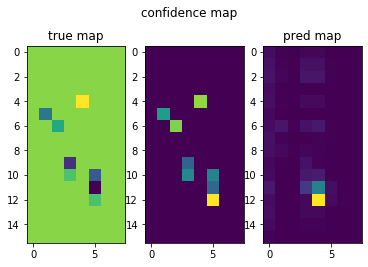

In [128]:
fig, axs= plt.subplots(1,3)
fig.suptitle('confidence map')
axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
axs[0].set_title('true map')
axs[1].imshow(y_true[0,:,:,2,0,4])
axs[2].set_title('pred map')
axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

In [8]:
def decode_netout(netout,  obj_thresh = 0.63, anchors=  anchors_list):
    input_shape = (16,8,5)
    original_input_shape = (512,128,40)
    
#     anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    grid_h, grid_w,grid_d = netout.shape[1:4]
    num_boxes = len(anchors)
    netout = netout.reshape((grid_h, grid_w, grid_d,num_boxes, -1))
    nb_class = netout.shape[-1] - 5
    
    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    
#     plt.figure()
#     plt.imshow(netout[:,:,2,0,4])
#     plt.show()
    
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for row in range(grid_h):
        for col in range(grid_w):
            for dep in range(grid_d):
                for b in range(num_boxes):
                    objectness = netout[row, col,dep, b, 4]
                    
                    if(objectness <= obj_thresh): continue
                    
                    x, y, w, h = netout[row,col,dep,b,:4]
                    x = (row + x)*(original_input_shape[0]/input_shape[0]) 
                    y = (col + y)*(original_input_shape[1]/input_shape[1])
                    w = anchors[b][0] * np.exp(w) 
                    h = anchors[b][1] * np.exp(h)   
                    classes = netout[row,col,dep,b,5:]
                    box = [x,y,w,h]
                    boxes.append(box)
#                     box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
#                     boxes.append(box)

    return boxes


In [142]:
print(targets)
y_true = preprocess_true_boxes(targets)
print('\n\n\n\n\n\n\n\n\n\n')
new_targets  = decode_netout(y_true,obj_thresh= 0.5)
new_targets[::6]

[[[ 24.5  157.75  66.75  20.    44.5 ]
  [ 26.   165.75  19.25  20.    29.5 ]
  [ 26.5  203.25  32.25  17.    50.5 ]
  [ 26.5  293.5   52.75  11.5   29.5 ]
  [ 26.5  324.    84.5   12.5   38.  ]
  [ 26.5  333.5   60.5   13.5   37.  ]
  [ 26.5  354.25  81.5    9.    39.  ]
  [ 26.5  387.25  83.5   18.    59.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]]]













[[150.94437980651855,
  72.68581295013428,
  20.03999948501587,
  44.619998931884766],
 [177.4336452484131, 24.809718132019043, 20.03999948501587, 29.62000072002411],
 [210.78388595581055,
  40.062499046325684,
  17.039999961853027,
  50.62000036239624],
 [305.37162590026855, 57.17885494232178, 11.53999924659729, 29.62000072002411],
 [339.3258171081543,
  58.975192070007324,
  13.539999723434448,
  37.12000250816345],
 [336.99870109558105, 89.11764240264893, 12.53999948501587, 38.11999797821045],
 [368.56226921081543, 88.37472629547119, 9.039999842643738, 39.11999702453613],
 [400.8118019104004,
  88.87152767181396,
  18.040000200271606,
  59.119999408721924]]

In [95]:
coords = y_true[0,4,4,2,2,:4]
print([32,16]*(coords[:2]+ [4,4]))
print(coords[2:4])

In [144]:
print(targets)
y_pred = model.predict([frame,targets])
boxes = decode_netout(y_pred, 0.5)
pprint.pprint(boxes[:6])
len(boxes)

[[[ 24.5  157.75  66.75  20.    44.5 ]
  [ 26.   165.75  19.25  20.    29.5 ]
  [ 26.5  203.25  32.25  17.    50.5 ]
  [ 26.5  293.5   52.75  11.5   29.5 ]
  [ 26.5  324.    84.5   12.5   38.  ]
  [ 26.5  333.5   60.5   13.5   37.  ]
  [ 26.5  354.25  81.5    9.    39.  ]
  [ 26.5  387.25  83.5   18.    59.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]]]
[]


0

In [138]:
def visualise_bird_view(frame,targets, boxes, do_nms = False):
    fig, axs = plt.subplots(1,2, figsize = (10,10))
    
    im = np.sum(frame,axis = (0,3,4))

    axs[0].imshow(im)
    axs[1].imshow(im)
    x_ticks = np.arange(0, im.shape[1], 20)
    y_ticks = np.arange(0, im.shape[0], 20)
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[1].set_xticks(x_ticks)
    axs[1].set_yticks(y_ticks)
    
    for num_target in range(targets.shape[1]):
        x = targets[0,num_target,2]
        y = targets[0,num_target,1]
        w = targets[0,num_target,4]
        h = targets[0,num_target,3]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
        
    for box in boxes:
        x = box[1]
        y = box[0]
        w = box[3]
        h = box[2]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[1].add_patch(rect)
        plt.savefig('comparison.png')

    
    

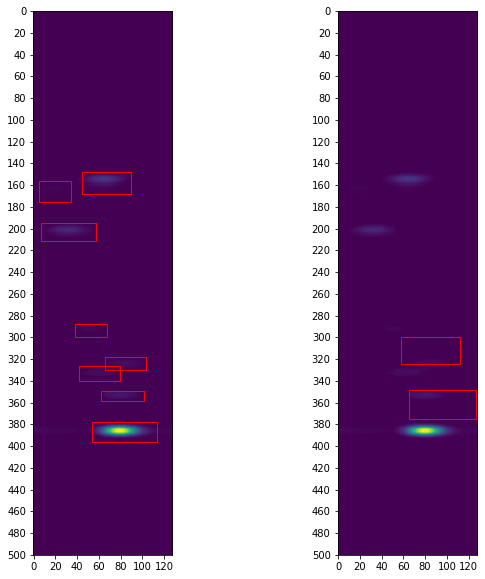

In [139]:
visualise_bird_view(frame,targets, boxes)

In [102]:
# pathname = os.path.abspath('data')
# counter_frames = 0 
# counter_boxes = 0
# for file in glob.glob(pathname+'/*.mat'):
#     matr = scipy.io.loadmat(file)
#     for num_frame in range(len(matr['Labels'])):
#         Labels = np.array(matr["Labels"][num_frame])
#         Labels = Labels/2
#         object_mask = Labels[Labels[:,0]>0,:]
#         if object_mask.shape[0] != 0:
#             counter_frames += 1
#             counter_boxes += object_mask.shape[0]
        
# print(counter_frames,counter_boxes)

# Visualisation

In [290]:
def vis_conflevels(y_pred):
    
    levels = []

    for ind in range(y_pred.shape[4]):
        level = y_pred[0,:,:,2,ind,4] + ind
        levels.append(level)
        
    data = [go.Surface(z=level, opacity= 0.9) for level in levels]

    fig = go.Figure(data = data)
    fig.show()

In [93]:
matr_val = frame[0,:,:,:,0]
# targets
print(matr_val.shape)
matr_val = ((matr_val - matr_val.min())/(matr_val.max() - matr_val.min()))

(512, 128, 40)


In [98]:
matr_np_cadr = np.zeros((512,128,40))
for i in range(512):
    for j in range(128):
        for k in range(40):
            if matr_val[i,j,k] > 0.0007:
                matr_np_cadr[i,j,k] = 1
matr_np_cadr.sum()

46596.0

<IPython.core.display.Javascript object>


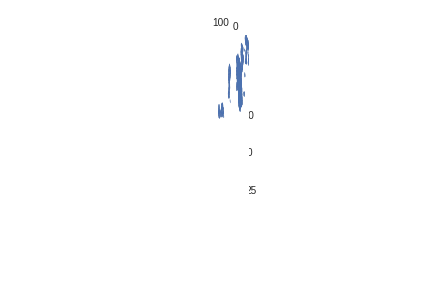

CPU times: user 49.6 s, sys: 303 ms, total: 49.9 s
Wall time: 49.7 s


In [99]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels((matr_np_cadr[:,:,:]))
plt.show()

In [101]:
frame = frame[0,:,:,:,0]

<IPython.core.display.Javascript object>


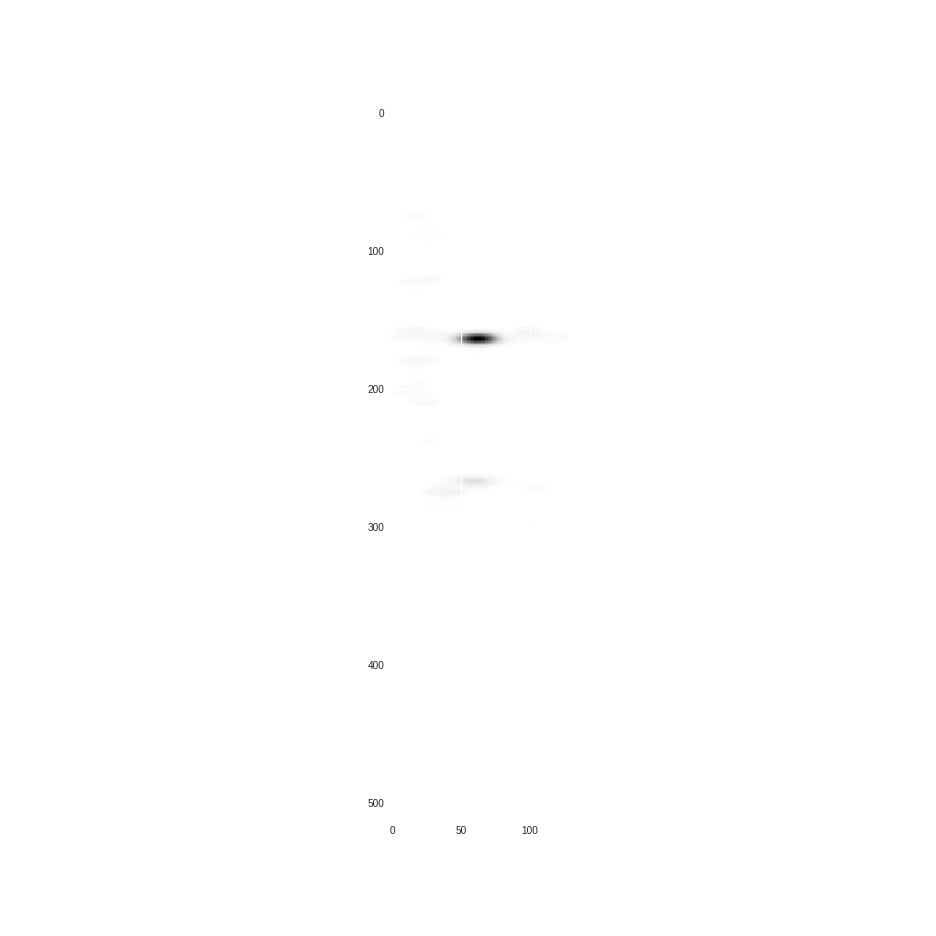

In [105]:
plt.figure(figsize = (13,13))
plt.imshow(np.(frame,axis = -1))
plt.show()

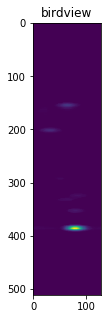

In [84]:
birdview_frame = np.sum(frame, axis = (0,3,4))
plt.figure(figsize= (5,5))
plt.imshow(birdview_frame)
plt.title('birdview')
plt.show()

In [485]:
import ipyvolume as ipv
from ipyvolume.pylab import figure
# V = np.zeros((128,128,128)) # our 3d array
V = frame[0,...,0]

f = figure()
ipv.quickvolshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.show()

In [2]:
import ipyvolume as ipv
import numpy as np
x, y, z = np.random.random((3, 10000))
ipv.quickscatter(x, y, z, size=1, marker="sphere")

In [4]:
import ipyvolume as ipv 

ds = ipv.datasets.aquariusA2.fetch()
fig = ipv.figure(debug=True)
s = 4
v0 = ipv.volshow(ds.data[::s,::s,::s], extent=[[0,100]]*3)
v1 = ipv.volshow(ds.data[::s,::s,::s], extent=[[75,175]]*3)
ipv.show()

/home/cognitive-comp/.local/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


# Модель 2

In [32]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax,zmin = 0, zmax = 80, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.zmin = zmin
        self.zmax = zmax
        self.c       = c
        
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]     
        return self.score  
    

def _sigmoid(x):
    return 1/(1 + np.exp(-x))

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis, keepdims=True)

def decode_netout(netout,  obj_thresh = 0.7, anchors=  anchors_list,):
#     netout = np.random.uniform(size = (1, 16, 8, 5, 6, 10))
#     netout = preprocess_true_boxes(1,2,3,5)
#     obj_thresh = 0.7
    input_shape = (16,8,5)
    original_input_shape = (512,128,40)
    
    grid_h, grid_w,grid_d = netout.shape[1:4]
    num_boxes = len(anchors)
    netout = netout.reshape((grid_h, grid_w, grid_d,num_boxes, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for row in range(grid_h):
        for col in range(grid_w):
            for dep in range(grid_d):
                for b in range(num_boxes):
                    objectness = netout[row, col,dep, b, 4]
                    if(objectness <= obj_thresh): continue
                    x, y, w, h = netout[row,col,dep,b,:4]
                    x = (col*(original_input_shape[0]/input_shape[0]) + x) 
                    y = (row*(original_input_shape[1]/input_shape[1]) + y)
                    w = anchors[b][0] * np.exp(w) 
                    h = anchors[b][1] * np.exp(h)   
                    classes = netout[row,col,dep,b,5:]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
                    boxes.append(box)

    return boxes

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h, new_d = net_w, net_h , net_d
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


def bbox_iou_norm_3d(box1,box2):
    box_intersect = Box()
    box_intersect.xmin = max(box1.xmin,box2.xmin)
    box_intersect.ymin = max(box1.ymin,box2.ymin)
    box_intersect.zmin = max(box1.zmin,box2.zmin)
    box_intersect.xmax = min(box1.xmax,box2.xmax)
    box_intersect.ymax = min(box1.ymax,box2.ymax)
    box_intersect.zmax = min(box1.zmax,box2.zmax)
    
    if box_intersect.xmin > box_intersect.xmax or box_intersect.ymin > box_intersect.ymax or box_intersect.zmin > box_intersect.zmax:
        intersect_vol = 0
    else:
        intersect_vol = box_intersect.get_vol()
    
    union_vol = box1.get_vol() + box2.get_vol() - intersect_vol 
    
    return intersect_vol/union_vol

def do_nms_exp(boxes, nms_thresh):
    if len(boxes) ==  0:
        return
    sorted_indices = np.argsort([-box[0] for box in boxes])
    for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]
        for j in range(i+1, len(sorted_indices)):
            index_j = sorted_indices[j]
            if bbox_iou_exp(boxes[index_i], boxes[index_j]) >= nms_thresh:
                boxes[index_j] = [0,0,0,0]
    return boxes
                
def bbox_iou_exp(box1, box2):
    intersect_w = _interval_overlap([box1[0] - box1[2] , box1[0]+ box1[2] ], [box2[0] - box2[2] , box2[0]+ box2[2]])
    intersect_h = _interval_overlap([box1[1] - box1[3] , box1[1]+ box1[3] ], [box2[1] - box2[3] , box2[1]+ box2[3]])
    intersect = intersect_w * intersect_h
    w1, h1 = box1[2], box1[3]
    w2, h2 = box2[2], box2[3]
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


In [475]:
print(len(boxes))
print(len(do_nms_exp(boxes, 0.2)))

13
13


In [ ]:
# код для чекания битых кадров

pathname = os.path.abspath('data')
for file in glob.glob(pathname+'/*.mat'):
    matr = scipy.io.loadmat(file)
    for num_frame in range(len(matr['Labels'])):
        Labels = np.array(matr["Labels"][num_frame])
        Labels = Labels/2
        object_mask = Labels[:,0]
        if object_mask.shape[0] != 0:
            true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
            print(file, num_frame,model.evaluate([frame,targets], y_true ))